In [1]:
%matplotlib inline

import numpy as np
from scipy.special import sph_harm, spherical_jn, spherical_yn

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import matplotlib.colors as colors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
hbar     = 1.054e-34  # J*m
c        = 299792458  # m/s
epsilon0 = 8.854e-12  # Vacuum permittivity (F/m)
pi       = np.pi

lambda0  = 1064e-9
omega0   = 2 * np.pi * c / lambda0
k0       = omega0 / c  # Wave number
E0       = 10          # Laser E-field
na       = 0.77
f        = 5e-3
f0       = 10          # Fill factor
w        = f0 * f * na # Beam waist after overfilling

epsilon  = 2.07  # Relative permittivity
# R        = 10e-6  # Sphere radius (m)
R        = 5e-9
k        = np.sqrt(epsilon) * omega0 / c
q        = k * R
q_prime  = np.sqrt(epsilon) * k * R

# In the optical domain can ignore the magnetic response
# n = sqrt(epsilon_dielectric/epsilon0 * mu_dielectric/mu_0)
n        = np.sqrt(epsilon) # Refractive index

## Beautiful math functions

Note that there are two indices for polarizations: `p` runs over TE and TM while `g` runs over 1 and 2.

In [63]:
def x_lm(l, m, theta, phi):
    """Vector spherical harmonics as defined in Hill (1954).
    
    :param l, m : integers
    :param theta: array_like
    :param phi  : array_like
    
    :return: theta and phi component, array_like. 
             Dim = dim(theta) = dim(phi)
      
    """
    # m, l are integers and abs(m) <= l
    if ( int(m) != m ) or ( int(l) != l ):
        return np.nan, np.nan
    elif np.abs(m) > l or l < 1:
        return 0, 0
    
    # Be careful - scipy defines polar and azimuthal
    # angles in an opposite convention
    # Also (-1)^m typically in Y_lm is in the associated Legendre function
    # Output of `scipy.special.sph_harm()` are sampled at (phi, theta)
    theta_comp = -1 * m * sph_harm(m, l, phi, theta) / ( np.sqrt(l * (l+1)) * np.sin(theta) )
    
    # Derivative of Y_ml w.r.t theta
    # https://functions.wolfram.com/Polynomials/SphericalHarmonicY/20/ShowAll.html
    dydtheta = m * 1/(np.tan(theta)) * sph_harm(m, l, phi, theta) + \
               np.sqrt((l-m) * (l+m+1)) * np.exp(-1j*phi) * sph_harm(m+1, l, phi, theta)
    phi_comp = ( -1j / np.sqrt(l*(l+1)) ) * dydtheta
    
    # X_lm has no r-component
    return theta_comp, phi_comp

In [4]:
# Unit vectors in spherical coords
e_theta = np.asarray([1, 0])
e_phi   = np.asarray([0, 1])

# Polarization vectors
def e_g(g):
    """Polarization vectors defined below Eq. (A3)"""
    if g == 1:
        return 1j * e_phi
    elif g == 2:
        return e_theta

In [45]:
def cbar_p_lmg(p, l, m, g, theta, phi):
    """Eq. (A2), (A3)"""
    if (g != 1) and (g != 2):
        return np.nan
    if ( int(m) != m ) or ( int(l) != l ):
        return np.nan
    elif np.abs(m) > l:
        return 0
    
    x_lm_theta_comp, x_lm_phi_comp = x_lm(l, m, theta, phi)
    if p == 'TE':
        return (1j)**l * (np.conjugate(x_lm_theta_comp) * e_g(g)[0] + np.conjugate(x_lm_phi_comp) * e_g(g)[1] )
    elif p == 'TM':
        # Using e_r x e_1 = -i e_2, e_r x e_2 = -i e_1
        g_prime = 2 if g == 1 else 1
        e_g_new = -1j * e_g(g_prime)
        return (1j)**l * (np.conjugate(x_lm_theta_comp) * e_g_new[0] + np.conjugate(x_lm_phi_comp) * e_g_new[1] )
    else:
        return np.nan

In [6]:
def z_lm(l, m, na, f, w):
    """Z_lm function related to Gaussian beam defined in Eq. (B10)
    
    Params
      l, m: integer indices
      na  : trapping NA 
      f   : focal length
      w   : waist
    """
    if ( int(m) != m ) or ( int(l) != l ):
        return np.asarray([np.nan, np.nan])
    elif np.abs(m) > l:
        return np.asarray([0, 0])
    
    theta_max = np.arcsin(na)
    
    tt = np.linspace(1e-8, theta_max, 200)
    int_factor = np.sin(tt) * np.sqrt(np.abs(np.cos(tt))) * np.exp(-1*f*f*np.sin(tt)*np.sin(tt) / (w*w))
    x_star_theta, x_star_phi = np.conjugate( x_lm(l, m, tt, np.zeros_like(tt)) )
    
    # Integrate over theta
    theta_comp = np.trapz(x_star_theta*int_factor, tt)
    phi_comp   = np.trapz(x_star_phi  *int_factor, tt)
    
    return np.asarray([theta_comp, phi_comp])

In [46]:
# Vectors used for `C_p_lm` below
def u_p(p):
    """Vectors defiend below Eq. (B9)"""
    if p == 'TE':
        return e_theta + 1j * e_phi
    elif p == 'TM':
        return e_phi - 1j * e_theta
    else:
        return np.nan

def C_p_lm(p, l, m, na, f, w):
    """C_p_lm function defined in Eq. (B9)"""
    if ( int(m) != m ) or ( int(l) != l ):
        return np.nan
    elif np.abs(m) > l:
        return 0
    elif ( l < 1 ):
        return 0
    
    prefactor = (1j)**l * k0 * f * E0 * np.sqrt(4 * np.pi**3 * epsilon0 / (hbar * omega0))
    
    if (m == 1):
        return prefactor * np.inner(z_lm(l, m, na, f, w), u_p(p))
    elif (m == -1):
        return prefactor * np.inner(z_lm(l, m, na, f, w), np.conjugate(u_p(p)))
    else:
        return 0

In [68]:
# Note that theta and phi already integrated over in `C_p_lm`
# polarization g has also been summed over
def Ax_p_lm(p, l, m, na, f, w, psi_l_mie=None):
    """Eq. (A20), `cbar_p_lm` replaced with `C_p_lm`"""
    if l == 0:
        return 0
    
    pbar   = 'TM' if (p == 'TE') else 'TE'
    
    first  = np.sqrt(l * (l+2) * (l-m+2) * (l-m+1) / ((2*l+3) * (2*l+1) * (2*l+2)**2)) * \
             C_p_lm(p, l+1, m-1, na, f, w) * S_p_l(p, l, psi_l_mie)
    second = -1 * np.sqrt((l-1) * (l+1) * (l-m) * (l-m-1) / ((2*l+1) * (2*l-1) * (2*l)**2)) * \
             C_p_lm(p, l-1, m+1, na, f, w) * np.conjugate(S_p_l(p, l-1, psi_l_mie))
    third  = -1 * np.sqrt(l * (l+2) * (l+m+2) * (l+m+1) / ((2*l+3) * (2*l+1) * (2*l+2)**2)) * \
             C_p_lm(p, l+1, m+1, na, f, w) * S_p_l(p, l, psi_l_mie)
    fourth = np.sqrt((l-1) * (l+1) * (l+m) * (l+m-1) / ((2*l+1) * (2*l-1) * (2*l)**2)) * \
             C_p_lm(p, l-1, m-1, na, f, w) * np.conjugate(S_p_l(p, l-1, psi_l_mie))
    fifth  = -1 * np.sqrt((l+m) * (l-m+1)) / (2 * l * (l+1)) * C_p_lm(pbar, l, m-1, na, f, w) * R_p_l(pbar, l, psi_l_mie)
    sixth  = -1 * np.sqrt((l+m+1) * (l-m)) / (2 * l * (l+1)) * C_p_lm(pbar, l, m+1, na, f, w) * R_p_l(pbar, l, psi_l_mie)

    return first + second + third + fourth + fifth + sixth

def Ay_p_lm(p, l, m, na, f, w, psi_l_mie=None):
    """Eq. (A21), `cbar_p_lm` replaced with `C_p_lm`"""
    if l == 0:
        return 0
    
    pbar   = 'TM' if (p == 'TE') else 'TE'
    
    first  = np.sqrt(l * (l+2) * (l-m+2) * (l-m+1) / ((2*l+3) * (2*l+1) * (2*l+2)**2)) * \
             C_p_lm(p, l+1, m-1, na, f, w) * S_p_l(p, l, psi_l_mie)
    second = np.sqrt((l-1) * (l+1) * (l-m) * (l-m-1) / ((2*l+1) * (2*l-1) * (2*l)**2)) * \
             C_p_lm(p, l-1, m+1, na, f, w) * np.conjugate(S_p_l(p, l-1, psi_l_mie))
    third  = np.sqrt(l * (l+2) * (l+m+2) * (l+m+1) / ((2*l+3) * (2*l+1) * (2*l+2)**2)) * \
             C_p_lm(p, l+1, m+1, na, f, w) * S_p_l(p, l, psi_l_mie)
    fourth = np.sqrt((l-1) * (l+1) * (l+m) * (l+m-1) / ((2*l+1) * (2*l-1) * (2*l)**2)) * \
             C_p_lm(p, l-1, m-1, na, f, w) * np.conjugate(S_p_l(p, l-1, psi_l_mie))
    fifth  = -1 * np.sqrt((l+m) * (l-m+1)) / (2 * l * (l+1)) * C_p_lm(pbar, l, m-1, na, f, w) * R_p_l(pbar, l, psi_l_mie)
    sixth  = np.sqrt((l+m+1) * (l-m)) / (2 * l * (l+1)) * C_p_lm(pbar, l, m+1, na, f, w) * R_p_l(pbar, l, psi_l_mie)

    return -1j * (first + second + third + fourth + fifth + sixth)

def Az_p_lm(p, l, m, na, f, w, psi_l_mie=None):
    """Eq. (A22), `cbar_p_lm` replaced with `C_p_lm`"""
    if l == 0:
        return 0
    
    pbar   = 'TM' if (p == 'TE') else 'TE'

    first  = np.sqrt(l * (l+2) * (l+1)**2 - m**2 / ((2*l+3) * (2*l+1) * (l+1)**2)) * \
             C_p_lm(p, l+1, m, na, f, w) * S_p_l(p, l, psi_l_mie)
    second = -1 * np.sqrt((l**2-1) * (l**2 - m**2) / ((4*(l**2) - 1) * l**2 )) * \
             C_p_lm(p, l-1, m, na, f, w) * np.conjugate(S_p_l(p, l-1, psi_l_mie))
    third  = -1 * m / (l * (l+1)) * C_p_lm(pbar, l, m, na, f, w) * R_p_l(pbar, l, psi_l_mie)
    
    return first + second + third

In [48]:
def R_p_l(p, l, psi_l_mie=None):
    # Use pre-calculated psi array if available
    if psi_l_mie is not None:
        ret = 1 - np.exp( -2j * (psi_l_mie['TM'][int(l)] - psi_l_mie['TE'][int(l)]) )
    else:
        ret = 1 - np.exp( -2j * (psi_p_l('TM', l) - psi_p_l('TE', l)) )
        
    if p == 'TE':
        return np.conjugate(-1 * ret)
    elif p == 'TM':
        return ret
    else:
        return np.nan

def S_p_l(p, l, psi_l_mie=None):
    # Take care of recursions that involve l-1
    if (l < 1):
        return 0
    else:
        if psi_l_mie is not None:
            if p == 'TE':
                return 1 - np.exp( -2j * (psi_l_mie['TE'][int(l+1)] - psi_l_mie['TE'][int(l)]) )
            elif p == 'TM':
                return 1 - np.exp( -2j * (psi_l_mie['TM'][int(l+1)] - psi_l_mie['TM'][int(l)]) )
            else:
                return np.nan
        else:
            return 1 - np.exp( -2j * (psi_p_l(p, l+1) - psi_p_l(p, l)) )

In [49]:
# Follow https://arxiv.org/pdf/2106.07975.pdf
# Eq. (50)-(54), (64), (65)
# These could be expressed in Mie's a, b coefficients
# It would be nice to check that they do agree
def psi_p_l(p, l):
    return np.arcsin( beta_p_l(p, l) / np.sqrt(alpha_p_l(p, l)**2 + beta_p_l(p, l)**2 ))

def alpha_p_l(p, l):
    if ( int(l) != l ):
        return np.nan
    
    if p == 'TE':
        first = q * q_prime * spherical_jn(l+1, q_prime) * spherical_yn(l, q)
        second = -1 * q**2 * spherical_jn(l, q_prime) * spherical_yn(l+1, q) 
        return (first + second)
    
    elif p == 'TM':
        first  = q**2 * spherical_jn(l+1, q_prime) * spherical_yn(l, q)
        second = -1 * q * q_prime * spherical_jn(l, q_prime) * spherical_yn(l+1, q)
        third  = q_prime * (1 - 1/epsilon) * (l+1) * spherical_jn(l, q_prime) * spherical_yn(l, q)
        return (first + second + third)
    
    else:
        return np.nan

def beta_p_l(p, l):
    if ( int(l) != l ):
        return np.nan
    
    if p == 'TE':
        first = q * q * spherical_jn(l, q_prime) * spherical_jn(l+1, q)
        second = -1 * q * q_prime * spherical_jn(l+1, q_prime) * spherical_jn(l, q) 
        return (first + second)
    
    elif p == 'TM':
        first  = q * q_prime * spherical_jn(l, q_prime) * spherical_jn(l+1, q)
        second = -1 * q * q * spherical_jn(l+1, q_prime) * spherical_jn(l, q)
        third  = -1 * q_prime * (1 - 1/epsilon) * (l+1) * spherical_jn(l, q_prime) * spherical_jn(l, q)
        return (first + second + third)
    
    else:
        return np.nan    

### Check the correctness of $\psi^p_l$ calcualtion

Use subroutines from Scott Prahl's `miepython` package to check the $\psi^p_l$ calculation. We expect
$$
    a_l = i \sin \psi^{\text{TM}}_l \exp(-i \psi^{\text{TM}}_l), \\
    b_l = i \sin \psi^{\text{TE}}_l \exp(-i \psi^{\text{TE}}_l).
$$

In [11]:
def _Lentz_Dn(z, N):
    """
    Compute the logarithmic derivative of the Ricatti-Bessel function.

    Args:
        z: function argument
        N: order of Ricatti-Bessel function

    Returns:
        This returns the Ricatti-Bessel function of order N with argument z
        using the continued fraction technique of Lentz, Appl. Opt., 15,
        668-671, (1976).
    """
    zinv = 2.0 / z
    alpha = (N + 0.5) * zinv
    aj = -(N + 1.5) * zinv
    alpha_j1 = aj + 1 / alpha
    alpha_j2 = aj
    ratio = alpha_j1 / alpha_j2
    runratio = alpha * ratio

    while np.abs(np.abs(ratio) - 1.0) > 1e-12:
        aj = zinv - aj
        alpha_j1 = 1.0 / alpha_j1 + aj
        alpha_j2 = 1.0 / alpha_j2 + aj
        ratio = alpha_j1 / alpha_j2
        zinv *= -1
        runratio = ratio * runratio

    return -N / z + runratio


def _D_downwards(z, N, D):
    """
    Compute the logarithmic derivative by downwards recurrence.

    Args:
        z: function argument
        N: order of Ricatti-Bessel function
        D: gets filled with the Ricatti-Bessel function values for orders
           from 0 to N for an argument z using the downwards recurrence relations.
    """
    last_D = _Lentz_Dn(z, N)
    for n in range(N, 0, -1):
        last_D = n / z - 1.0 / (last_D + n / z)
        D[n - 1] = last_D


def _D_upwards(z, N, D):
    """
    Compute the logarithmic derivative by upwards recurrence.

    Args:
        z: function argument
        N: order of Ricatti-Bessel function
        D: gets filled with the Ricatti-Bessel function values for orders
           from 0 to N for an argument z using the upwards recurrence relations.
    """
    exp = np.exp(-2j * z)
    D[1] = -1 / z + (1 - exp) / ((1 - exp) / z - 1j * (1 + exp))
    for n in range(2, N):
        D[n] = 1 / (n / z - D[n - 1]) - n / z


def _D_calc(m, x, N):
    """
    Compute the logarithmic derivative using best method.

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere
        N: order of Ricatti-Bessel function

    Returns:
        The values of the Ricatti-Bessel function for orders from 0 to N.
    """
    n = m.real
    kappa = np.abs(m.imag)
    D = np.zeros(N, dtype=np.complex128)

    if n < 1 or n > 10 or kappa > 10 or x * kappa >= 3.9 - 10.8 * n + 13.78 * n**2:
        _D_downwards(m * x, N, D)
    else:
        _D_upwards(m * x, N, D)
    return D


def mie_An_Bn(m, x, nmax):
    """
    Compute arrays of Mie coefficients A and B for a sphere.

    This estimates the size of the arrays based on Wiscombe's formula. The length
    of the arrays is chosen so that the error when the series are summed is
    around 1e-6.

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere
        
        Added 2023/05/23
        nmax: maximum n for the caculation

    Returns:
        An, Bn: arrays of Mie coefficents
    """
    # This is the citerion used in the original program
    # nstop = int(x + 4.05 * x**0.33333 + 2.0) + 1
    nstop = nmax + 1
    
    a = np.zeros(nstop - 1, dtype=np.complex128)
    b = np.zeros(nstop - 1, dtype=np.complex128)

    psi_nm1 = np.sin(x)                   # nm1 = n-1 = 0
    psi_n = psi_nm1 / x - np.cos(x)       # n = 1
    xi_nm1 = complex(psi_nm1, np.cos(x))
    xi_n = complex(psi_n, np.cos(x) / x + np.sin(x))

    if m.real > 0.0:
        D = _D_calc(m, x, nstop + 1)

        for n in range(1, nstop):
            temp = D[n] / m + n / x
            a[n - 1] = (temp * psi_n - psi_nm1) / (temp * xi_n - xi_nm1)
            temp = D[n] * m + n / x
            b[n - 1] = (temp * psi_n - psi_nm1) / (temp * xi_n - xi_nm1)
            xi = (2 * n + 1) * xi_n / x - xi_nm1
            xi_nm1 = xi_n
            xi_n = xi
            psi_nm1 = psi_n
            psi_n = xi_n.real

    else:
        for n in range(1, nstop):
            a[n - 1] = (n * psi_n / x - psi_nm1) / (n * xi_n / x - xi_nm1)
            b[n - 1] = psi_n / xi_n
            xi = (2 * n + 1) * xi_n / x - xi_nm1
            xi_nm1 = xi_n
            xi_n = xi
            psi_nm1 = psi_n
            psi_n = xi_n.real

    return a, b

In [12]:
# Mie coefs a_n, b_n up to n = 49
x = 2 * np.pi * R / lambda0
an, bn = mie_An_Bn(n, x, nmax=49)

In [13]:
an_ = np.insert(an, 0, np.nan)
bn_ = np.insert(bn, 0, np.nan)

In [14]:
# Now calculate from our fomulas
al = np.empty(50, dtype=np.complex128)
bl = np.empty(50, dtype=np.complex128)

for i in range(50):
    al[i] = 1j * np.sin(psi_p_l('TM', i)) * np.exp(-1j * psi_p_l('TM', i))
    bl[i] = 1j * np.sin(psi_p_l('TE', i)) * np.exp(-1j * psi_p_l('TE', i))

They don't agree with each other for some reason.

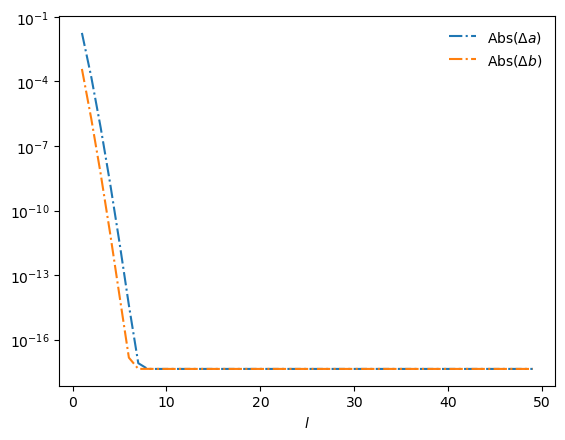

In [15]:
plt.plot(np.arange(50), np.abs(an_ - al), '-.', label='Abs($\Delta a$)')
plt.plot(np.arange(50), np.abs(bn_ - bl), '-.', label='Abs($\Delta b$)')

plt.yscale('log')
plt.xlabel('$l$')
plt.legend(frameon=False)

In [16]:
def psi_p_l_mie(p, lmax):
    """
    Calculate psi_p_l from Mie a, b coefficients up to lmax
    """
    al, bl = mie_An_Bn(np.sqrt(epsilon), 2 * np.pi * R / lambda0, lmax)
    if p == 'TM':
        return 0.5 * 1j * np.log(1 - 0.5 * al)
    elif p == 'TE':
        return 0.5 * 1j * np.log(1 - 0.5 * al)
    else:
        return np.nan

## Information radiation density

In [65]:
def info_density(axis, theta, phi, na, f, w, lmax=50, use_mie=True):
    if axis == 'x':
        info_func = Ax_p_lm
    elif axis == 'y':
        info_func = Ay_p_lm
    elif axis == 'z':
        info_func = Az_p_lm

    if use_mie:
        # Pre-calculate psi_p_l from mie coefficients
        # `lmax+10` because there might be larger l needed
        psi_te_l  = np.insert( psi_p_l_mie('TE', lmax+10), 0, np.nan)
        psi_tm_l  = np.insert( psi_p_l_mie('TM', lmax+10), 0, np.nan)
        psi_l_mie = dict([('TE', psi_te_l), ('TM', psi_tm_l)])
    else:
        psi_l_mie = None
    
    sum_glmp = np.zeros_like(theta)
    sum_lmp_denominator = 0
    
    for g in [1, 2]:
        sum_lmp_nominator = np.zeros_like(theta, dtype=np.complex128)

        for l in np.arange(0, lmax + 1):
            for m in np.arange(-1*l, l+1, step=1, dtype=np.intc):
                for p in ['TE', 'TM']:
                    cbar = np.nan_to_num(cbar_p_lmg(p, l, m, g, theta, phi), nan=0)
                    A_mu = np.nan_to_num(info_func(p, l, m, na, f, w, psi_l_mie), nan=0)
                    
#                     print(f'g, l, m, p = {g}, {l}, {m}, {p}')
#                     print(cbar_p_lmg(p, l, m, g, theta, phi), info_func(p, l, m, na, f, w, psi_l_mie))
                    
                    sum_lmp_nominator += ( np.conjugate(cbar) * A_mu )
                    
                    # To avoid overcounting because we don't need to sum
                    # over `g` for the denominator
                    if g == 1:
                        sum_lmp_denominator += ( np.abs(A_mu)**2 )
                        
        sum_glmp += np.abs(sum_lmp_nominator)**2 
    
    return sum_glmp / sum_lmp_denominator

In [83]:
theta = np.linspace(1e-8, np.pi, 200)
phi = np.linspace(0, 2*np.pi, 200)
tt, pp = np.meshgrid(theta, phi)

info_x = info_density('x', tt, pp, na, f, w, 10, use_mie=False)
info_y = info_density('y', tt, pp, na, f, w, 10, use_mie=False)
info_z = info_density('z', tt, pp, na, f, w, 10, use_mie=False)

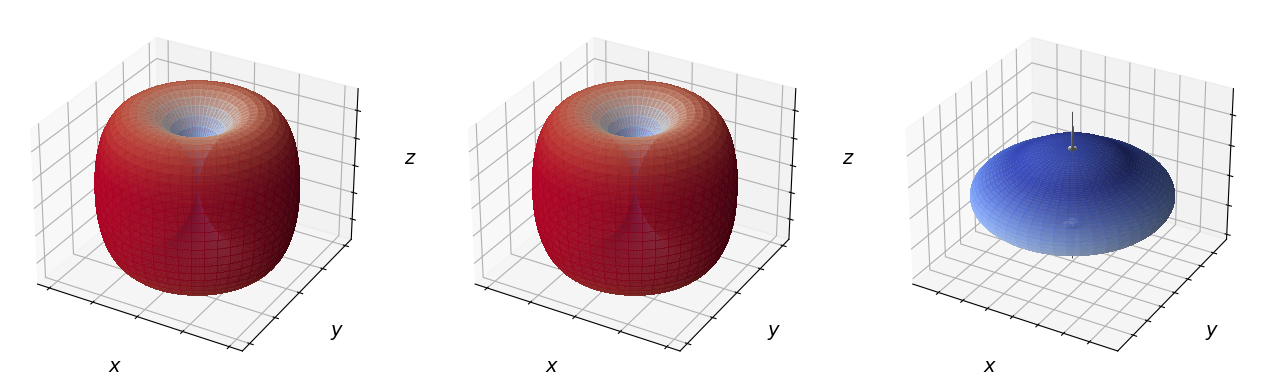

In [84]:
cmap = plt.get_cmap('coolwarm')
info_den = [info_x, info_y, info_z]

fig = plt.figure(figsize=(16, 7))
for i, den in enumerate(info_den):
    norm = colors.Normalize(vmin=den.min(), vmax=den.max())
    
    # Project magnitude onto x, y, and z components, for plotting purpose
    xx = den * np.sin(tt) * np.cos(pp)
    yy = den * np.sin(tt) * np.sin(pp)
    zz = den * np.cos(tt)
    
    ax = fig.add_subplot(1, len(info_den), i+1, projection='3d')
    plot = ax.plot_surface(
        xx, yy, zz, facecolors=cmap(norm(den)),
        linewidth=0, antialiased=False, alpha=0.8)

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(r'$x$', fontsize=14)
    ax.set_ylabel(r'$y$', fontsize=14)
    ax.set_zlabel(r'$z$', fontsize=14)
plt.show()